In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, 
    confusion_matrix, classification_report, f1_score, matthews_corrcoef
)

sns.set(style="whitegrid")
print("Packages imported.")

Packages imported.


In [ ]:
# We'll create two lists: one for LARS-avg (mean) and one for LARS-max (max).
model_preds_avg = []  # per model aggregated predictions (LARS-avg)
model_preds_max = []  # per model aggregated predictions (LARS-max)

# Group by scan_id to aggregate the predictions for the individual MIP views.
# We assume each file contains a 'scan_id', a 'probs' column, and optionally a 'target' column.
df_avg = df.groupby('scan_id').agg({'probs': 'mean', 'target': 'first'}).reset_index()
df_max = df.groupby('scan_id').agg({'probs': 'max', 'target': 'first'}).reset_index()
model_preds_avg.append(df_avg)
model_preds_max.append(df_max)

# STEP 2: Ensemble across models
# For each ensemble, we merge only the probability columns from the subsequent models,
# while retaining the 'target' from the first model.
ensemble_avg = model_preds_avg[0].rename(columns={'probs': 'probs_model0'})
for i, df_avg in enumerate(model_preds_avg[1:], start=1):
    df_avg = df_avg.rename(columns={'probs': f'probs_model{i}'})
    # Only merge the probability column, not the 'target'
    ensemble_avg = pd.merge(ensemble_avg, df_avg[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

ensemble_max = model_preds_max[0].rename(columns={'probs': 'probs_model0'})
for i, df_max in enumerate(model_preds_max[1:], start=1):
    df_max = df_max.rename(columns={'probs': f'probs_model{i}'})
    ensemble_max = pd.merge(ensemble_max, df_max[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

# Compute the final ensemble prediction per scan by averaging across models.
model_cols_avg = [col for col in ensemble_avg.columns if col.startswith('probs_model')]
ensemble_avg['ensemble_prob'] = ensemble_avg[model_cols_avg].mean(axis=1)

model_cols_max = [col for col in ensemble_max.columns if col.startswith('probs_model')]
ensemble_max['ensemble_prob'] = ensemble_max[model_cols_max].mean(axis=1)

# --- Step 1: Calculate ROC AUC for each ensemble ---
auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
auc_max = roc_auc_score(ensemble_max['target'], ensemble_max['ensemble_prob'])

print("Ensemble ROC AUC (LARS-avg):", auc_avg)
print("Ensemble ROC AUC (LARS-max):", auc_max)
print("\n")
# --- Step 2: Optimal threshold using Youden's index for LARS-avg ---
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
youden_index_avg = tpr_avg - fpr_avg
optimal_idx_avg = np.argmax(youden_index_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

ensemble_avg['pred_label'] = (ensemble_avg['ensemble_prob'] >= optimal_threshold_avg).astype(int)
acc_avg_optimal = accuracy_score(ensemble_avg['target'], ensemble_avg['pred_label'])
mcc_avg = matthews_corrcoef(ensemble_avg['target'], ensemble_avg['pred_label'])

# --- Step 3: Optimal threshold using Youden's index for LARS-max ---
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
youden_index_max = tpr_max - fpr_max
optimal_idx_max = np.argmax(youden_index_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]

ensemble_max['pred_label'] = (ensemble_max['ensemble_prob'] >= optimal_threshold_max).astype(int)
acc_max_optimal = accuracy_score(ensemble_max['target'], ensemble_max['pred_label'])
mcc_max = matthews_corrcoef(ensemble_max['target'], ensemble_max['pred_label'])

# --- Step 4: Print results ---
print("Optimal threshold (LARS-avg):", optimal_threshold_avg)
print("Accuracy (LARS-avg):", acc_avg_optimal)

print("MCC (LARS-avg):", mcc_avg)
print("\n")
print("Optimal threshold (LARS-max):", optimal_threshold_max)
print("Accuracy (LARS-max):", acc_max_optimal)
print("MCC (LARS-max):", mcc_max)



# Save the final ensemble predictions to CSV files.
ensemble_avg.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_avg.csv", index=False)
ensemble_max.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_max.csv", index=False)


Ensemble ROC AUC (LARS-avg): 0.7783874205419872
Ensemble ROC AUC (LARS-max): 0.7712947474071595


Optimal threshold (LARS-avg): 0.44651428220095113
Accuracy (LARS-avg): 0.8594771241830066
MCC (LARS-avg): 0.5102256444528681


Optimal threshold (LARS-max): 0.096406802535057
Accuracy (LARS-max): 0.738562091503268
MCC (LARS-max): 0.3629738387468919


NameError: name 'loc_mapping' is not defined

Detailed Classification Report (LARS-avg External Validation):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.72      0.48      0.57        61

    accuracy                           0.86       306
   macro avg       0.80      0.72      0.75       306
weighted avg       0.85      0.86      0.85       306


Detailed Classification Report (LARS-max External Validation):
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       245
           1       0.41      0.67      0.51        61

    accuracy                           0.74       306
   macro avg       0.65      0.71      0.66       306
weighted avg       0.80      0.74      0.76       306



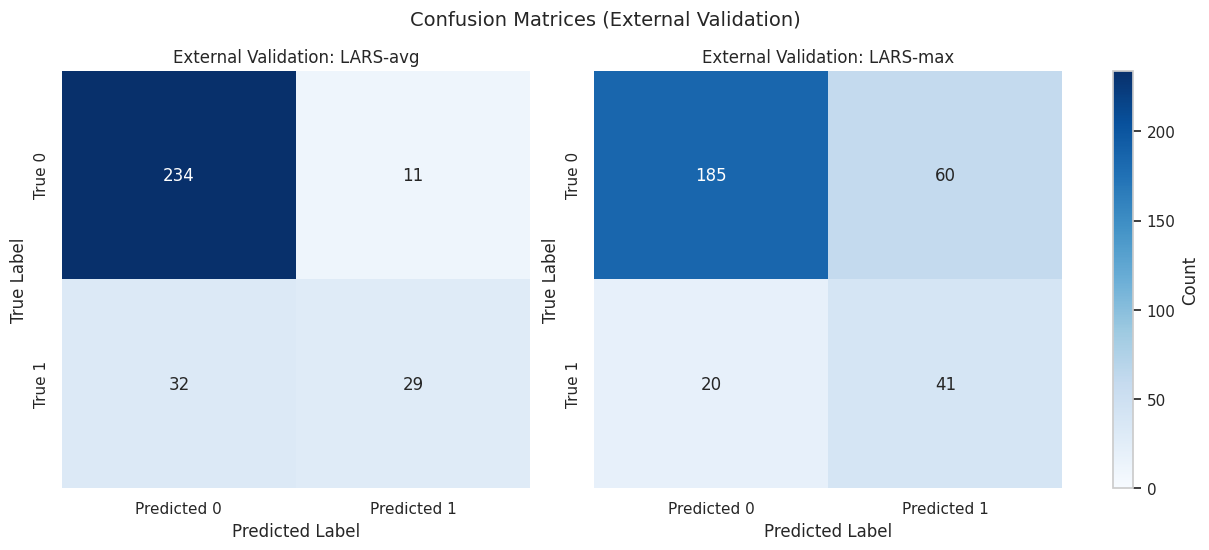


LARS-avg External Validation: False Positives: 11, False Negatives: 32
LARS-max External Validation: False Positives: 60, False Negatives: 20


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume ensemble_avg and ensemble_max DataFrames are already available
# and they contain at least the following columns: 'target', 'pred_label', and 'scan_id'

# Compute confusion matrices for both variants
cm_avg = confusion_matrix(ensemble_avg['target'], ensemble_avg['pred_label'])
cm_max = confusion_matrix(ensemble_max['target'], ensemble_max['pred_label'])

# Print detailed classification reports for both
print("Detailed Classification Report (LARS-avg External Validation):")
print(classification_report(ensemble_avg['target'], ensemble_avg['pred_label']))
print("\nDetailed Classification Report (LARS-max External Validation):")
print(classification_report(ensemble_max['target'], ensemble_max['pred_label']))

# Determine the maximum value across both confusion matrices for shared scaling
max_val = max(cm_avg.max(), cm_max.max())

# 3) Determine the maximum value across both confusion matrices for a shared scale
max_val = max(cm_avg.max(), cm_max.max())

# 4) Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# We'll first plot each heatmap with cbar=False so we can add a single color bar after.
im0 = sns.heatmap(cm_avg, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[0],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[0].set_title("External Validation: LARS-avg")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

im1 = sns.heatmap(cm_max, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[1],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[1].set_title("External Validation: LARS-max")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# 5) Add one common color bar using the first heatmap's “collections”
cbar = fig.colorbar(im0.collections[0], ax=axs, shrink=1, label='Count')


plt.suptitle("Confusion Matrices (External Validation)", fontsize=14, y=1.07)
plt.show()
plt.show()

# Report false positives and false negatives for each variant
fp_avg = ensemble_avg[(ensemble_avg['target'] == 0) & (ensemble_avg['pred_label'] == 1)]
fn_avg = ensemble_avg[(ensemble_avg['target'] == 1) & (ensemble_avg['pred_label'] == 0)]
fp_max = ensemble_max[(ensemble_max['target'] == 0) & (ensemble_max['pred_label'] == 1)]
fn_max = ensemble_max[(ensemble_max['target'] == 1) & (ensemble_max['pred_label'] == 0)]

print(f"\nLARS-avg External Validation: False Positives: {len(fp_avg)}, False Negatives: {len(fn_avg)}")
print(f"LARS-max External Validation: False Positives: {len(fp_max)}, False Negatives: {len(fn_max)}")


/home/mezher/Documents/Deauville_DeepLearning/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mezher/Documents/Deauville_DeepLearning/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mezher/Documents/Deauville_DeepLearning/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Loc Accuracy: 0.565, Balanced Acc: 0.124
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         5
           3       1.00      0.08      0.15        12
           4       0.00      0.00      0.00         7
           5       0.33      0.40      0.36         5
           6       0.27      0.09      0.14        33
           7       0.07      0.11      0.09         9
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         2
          12       0.18      0.12      0.14        17
          13       0.64      0.93      0.76       177

    accuracy                           0.57       306
   macro avg       0.18      0.12      0.12       306
weighted avg       0.46      0.57      

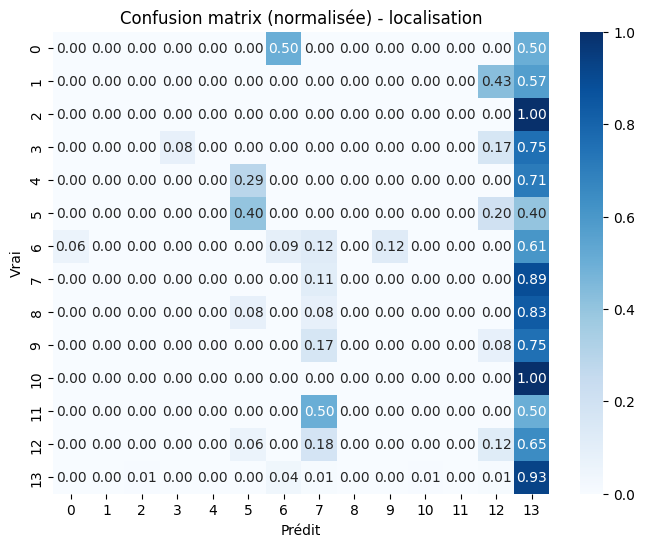

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the mapping dictionary (from original values to consecutive integer labels)
loc_mapping = {
    1.0: 0,
    2.0: 1,
    5.0: 2,
    6.0: 3,
    7.0: 4,
    8.0: 5,
    9.0: 6,
    10.0: 7,
    11.0: 8,
    20.0: 9,
    25.0: 10,
    27.0: 11,
    28.0: 12,
    51.0: 13
}

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Charge ton CSV “raw”
df = pd.read_csv('pred_split0_run0.csv')

# 2) Mappe la GT
df['true_loc'] = df['target_loc'].map(loc_mapping)

# 3) Moyenne les proba L0…L13 par scan
loc_cols = [f'L{i}' for i in range(14)]
df_scan = df.groupby('scan_id')[loc_cols].mean().reset_index()

# 4) Récupère la GT unique
gt = df[['scan_id','true_loc']].drop_duplicates(subset='scan_id')
df_scan = df_scan.merge(gt, on='scan_id')

# 5) Argmax sur les proba moyennées
probs = df_scan[loc_cols].values
df_scan['pred_loc'] = np.argmax(probs, axis=1)

# 6) Metrics
acc     = accuracy_score(df_scan['true_loc'], df_scan['pred_loc'])
b_acc   = balanced_accuracy_score(df_scan['true_loc'], df_scan['pred_loc'])
report  = classification_report(df_scan['true_loc'], df_scan['pred_loc'])
cm      = confusion_matrix(df_scan['true_loc'], df_scan['pred_loc'])

print(f"Loc Accuracy: {acc:.3f}, Balanced Acc: {b_acc:.3f}")
print(report)

# 7) Heatmap normalisée
plt.figure(figsize=(8,6))
sns.heatmap(cm/ cm.sum(axis=1, keepdims=True), annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion matrix (normalisée) - localisation")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, 
    confusion_matrix, classification_report, f1_score, matthews_corrcoef
)

sns.set(style="whitegrid")
print("Packages imported.")

Packages imported.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, 
    confusion_matrix, classification_report, f1_score, matthews_corrcoef
)

sns.set(style="whitegrid")
print("Packages imported.")

Packages imported.


In [ ]:
# ## Step 1. Load and Inspect Predictions CSV
#
# We load the CSV file (e.g. pred_split0_run0.csv) and check the columns.

# %% [code]
# Change the path as needed
csv_file = "/home/mezher/Documents/Deauville_DeepLearning/localization_prediction/pred_split0_run0.csv"
df = pd.read_csv(csv_file)
print("Columns in the CSV file:")
print(df.columns.tolist())

# Display the first few rows.
print("Preview of the prediction data:")
display(df.head())

Columns in the CSV file:
['patient_id', 'study_id', 'scan_id', 'filename', 'matrix_size_1', 'matrix_size_2', 'target', 'target_loc', 'set', 'probs', 'pred_loc', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F89', 'F90', 'F91', 'F92', 'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'F101', 'F102', 'F103', 'F104', 'F105', 'F106', 'F107', 'F108', 'F109', 'F110', 'F111', 'F112', 'F113', 'F114', 'F115', 'F116', 'F117', 'F118', 'F1

,patient_id,study_id,scan_id,filename,matrix_size_1,matrix_size_2,target,target_loc,set,probs,...,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13
0,401421720,DeepDeauville 1503,33,images/DeepDeauville 1503_cor.npy,310,161,0,9.0,test,0.000048,...,0.002252,0.001174,0.016810,0.015111,0.000861,0.000431,0.002401,0.001051,0.002669,0.950000
1,401421720,DeepDeauville 1503,33,images/DeepDeauville 1503_sag.npy,310,161,0,9.0,test,0.000665,...,0.004558,0.002455,0.005295,0.015658,0.002170,0.001289,0.002494,0.003222,0.008532,0.931946
2,401421720,DeepDeauville 0675,34,images/DeepDeauville 0675_cor.npy,310,161,0,51.0,test,0.001159,...,0.005110,0.003846,0.008372,0.004684,0.028699,0.007282,0.005035,0.003416,0.006947,0.881898
3,401421720,DeepDeauville 0675,34,images/DeepDeauville 0675_sag.npy,310,161,0,51.0,test,0.000426,...,0.018576,0.001682,0.000912,0.004829,0.010869,0.000783,0.005724,0.005525,0.010597,0.913691
4,400186017,DeepDeauville 0747,35,images/DeepDeauville 0747_cor.npy,310,161,1,20.0,test,0.671133,...,0.058325,0.040097,0.026901,0.344600,0.026195,0.045328,0.017184,0.040559,0.141253,0.054512


In [ ]:
# We'll create two lists: one for LARS-avg (mean) and one for LARS-max (max).
model_preds_avg = []  # per model aggregated predictions (LARS-avg)
model_preds_max = []  # per model aggregated predictions (LARS-max)

# Group by scan_id to aggregate the predictions for the individual MIP views.
# We assume each file contains a 'scan_id', a 'probs' column, and optionally a 'target' column.
df_avg = df.groupby('scan_id').agg({'probs': 'mean', 'target': 'first'}).reset_index()
df_max = df.groupby('scan_id').agg({'probs': 'max', 'target': 'first'}).reset_index()
model_preds_avg.append(df_avg)
model_preds_max.append(df_max)

# STEP 2: Ensemble across models
# For each ensemble, we merge only the probability columns from the subsequent models,
# while retaining the 'target' from the first model.
ensemble_avg = model_preds_avg[0].rename(columns={'probs': 'probs_model0'})
for i, df_avg in enumerate(model_preds_avg[1:], start=1):
    df_avg = df_avg.rename(columns={'probs': f'probs_model{i}'})
    # Only merge the probability column, not the 'target'
    ensemble_avg = pd.merge(ensemble_avg, df_avg[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

ensemble_max = model_preds_max[0].rename(columns={'probs': 'probs_model0'})
for i, df_max in enumerate(model_preds_max[1:], start=1):
    df_max = df_max.rename(columns={'probs': f'probs_model{i}'})
    ensemble_max = pd.merge(ensemble_max, df_max[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

# Compute the final ensemble prediction per scan by averaging across models.
model_cols_avg = [col for col in ensemble_avg.columns if col.startswith('probs_model')]
ensemble_avg['ensemble_prob'] = ensemble_avg[model_cols_avg].mean(axis=1)

model_cols_max = [col for col in ensemble_max.columns if col.startswith('probs_model')]
ensemble_max['ensemble_prob'] = ensemble_max[model_cols_max].mean(axis=1)

# --- Step 1: Calculate ROC AUC for each ensemble ---
auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
auc_max = roc_auc_score(ensemble_max['target'], ensemble_max['ensemble_prob'])

print("Ensemble ROC AUC (LARS-avg):", auc_avg)
print("Ensemble ROC AUC (LARS-max):", auc_max)
print("\n")
# --- Step 2: Optimal threshold using Youden's index for LARS-avg ---
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
youden_index_avg = tpr_avg - fpr_avg
optimal_idx_avg = np.argmax(youden_index_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

ensemble_avg['pred_label'] = (ensemble_avg['ensemble_prob'] >= optimal_threshold_avg).astype(int)
acc_avg_optimal = accuracy_score(ensemble_avg['target'], ensemble_avg['pred_label'])
mcc_avg = matthews_corrcoef(ensemble_avg['target'], ensemble_avg['pred_label'])

# --- Step 3: Optimal threshold using Youden's index for LARS-max ---
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
youden_index_max = tpr_max - fpr_max
optimal_idx_max = np.argmax(youden_index_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]

ensemble_max['pred_label'] = (ensemble_max['ensemble_prob'] >= optimal_threshold_max).astype(int)
acc_max_optimal = accuracy_score(ensemble_max['target'], ensemble_max['pred_label'])
mcc_max = matthews_corrcoef(ensemble_max['target'], ensemble_max['pred_label'])

# --- Step 4: Print results ---
print("Optimal threshold (LARS-avg):", optimal_threshold_avg)
print("Accuracy (LARS-avg):", acc_avg_optimal)

print("MCC (LARS-avg):", mcc_avg)
print("\n")
print("Optimal threshold (LARS-max):", optimal_threshold_max)
print("Accuracy (LARS-max):", acc_max_optimal)
print("MCC (LARS-max):", mcc_max)



# Save the final ensemble predictions to CSV files.
ensemble_avg.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_avg.csv", index=False)
ensemble_max.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_max.csv", index=False)


Ensemble ROC AUC (LARS-avg): 0.7783874205419872
Ensemble ROC AUC (LARS-max): 0.7712947474071595


Optimal threshold (LARS-avg): 0.44651428220095113
Accuracy (LARS-avg): 0.8594771241830066
MCC (LARS-avg): 0.5102256444528681


Optimal threshold (LARS-max): 0.096406802535057
Accuracy (LARS-max): 0.738562091503268
MCC (LARS-max): 0.3629738387468919


Detailed Classification Report (LARS-avg External Validation):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.72      0.48      0.57        61

    accuracy                           0.86       306
   macro avg       0.80      0.72      0.75       306
weighted avg       0.85      0.86      0.85       306


Detailed Classification Report (LARS-max External Validation):
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       245
           1       0.41      0.67      0.51        61

    accuracy                           0.74       306
   macro avg       0.65      0.71      0.66       306
weighted avg       0.80      0.74      0.76       306



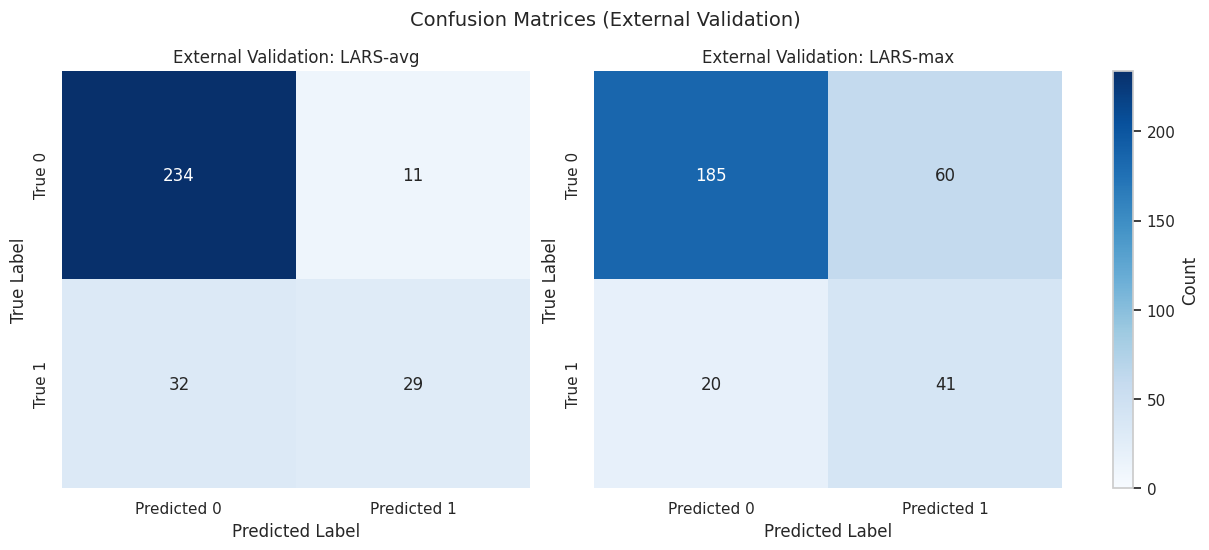


LARS-avg External Validation: False Positives: 11, False Negatives: 32
LARS-max External Validation: False Positives: 60, False Negatives: 20


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume ensemble_avg and ensemble_max DataFrames are already available
# and they contain at least the following columns: 'target', 'pred_label', and 'scan_id'

# Compute confusion matrices for both variants
cm_avg = confusion_matrix(ensemble_avg['target'], ensemble_avg['pred_label'])
cm_max = confusion_matrix(ensemble_max['target'], ensemble_max['pred_label'])

# Print detailed classification reports for both
print("Detailed Classification Report (LARS-avg External Validation):")
print(classification_report(ensemble_avg['target'], ensemble_avg['pred_label']))
print("\nDetailed Classification Report (LARS-max External Validation):")
print(classification_report(ensemble_max['target'], ensemble_max['pred_label']))

# Determine the maximum value across both confusion matrices for shared scaling
max_val = max(cm_avg.max(), cm_max.max())

# 3) Determine the maximum value across both confusion matrices for a shared scale
max_val = max(cm_avg.max(), cm_max.max())

# 4) Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# We'll first plot each heatmap with cbar=False so we can add a single color bar after.
im0 = sns.heatmap(cm_avg, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[0],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[0].set_title("External Validation: LARS-avg")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

im1 = sns.heatmap(cm_max, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[1],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[1].set_title("External Validation: LARS-max")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# 5) Add one common color bar using the first heatmap's “collections”
cbar = fig.colorbar(im0.collections[0], ax=axs, shrink=1, label='Count')


plt.suptitle("Confusion Matrices (External Validation)", fontsize=14, y=1.07)
plt.show()
plt.show()

# Report false positives and false negatives for each variant
fp_avg = ensemble_avg[(ensemble_avg['target'] == 0) & (ensemble_avg['pred_label'] == 1)]
fn_avg = ensemble_avg[(ensemble_avg['target'] == 1) & (ensemble_avg['pred_label'] == 0)]
fp_max = ensemble_max[(ensemble_max['target'] == 0) & (ensemble_max['pred_label'] == 1)]
fn_max = ensemble_max[(ensemble_max['target'] == 1) & (ensemble_max['pred_label'] == 0)]

print(f"\nLARS-avg External Validation: False Positives: {len(fp_avg)}, False Negatives: {len(fn_avg)}")
print(f"LARS-max External Validation: False Positives: {len(fp_max)}, False Negatives: {len(fn_max)}")


In [ ]:
# ## Step 1. Load and Inspect Predictions CSV
#
# We load the CSV file (e.g. pred_split0_run0.csv) and check the columns.

# %% [code]
# Change the path as needed
csv_file = "/home/mezher/Documents/Deauville_DeepLearning/localization_prediction/pred_split0_run0.csv"
df = pd.read_csv(csv_file)
print("Columns in the CSV file:")
print(df.columns.tolist())

# Display the first few rows.
print("Preview of the prediction data:")
display(df.head())

Columns in the CSV file:
['patient_id', 'study_id', 'scan_id', 'filename', 'matrix_size_1', 'matrix_size_2', 'target', 'target_loc', 'set', 'probs', 'pred_loc', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F89', 'F90', 'F91', 'F92', 'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'F101', 'F102', 'F103', 'F104', 'F105', 'F106', 'F107', 'F108', 'F109', 'F110', 'F111', 'F112', 'F113', 'F114', 'F115', 'F116', 'F117', 'F118', 'F1

,patient_id,study_id,scan_id,filename,matrix_size_1,matrix_size_2,target,target_loc,set,probs,...,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13
0,401421720,DeepDeauville 1503,33,images/DeepDeauville 1503_cor.npy,310,161,0,9.0,test,0.000048,...,0.002252,0.001174,0.016810,0.015111,0.000861,0.000431,0.002401,0.001051,0.002669,0.950000
1,401421720,DeepDeauville 1503,33,images/DeepDeauville 1503_sag.npy,310,161,0,9.0,test,0.000665,...,0.004558,0.002455,0.005295,0.015658,0.002170,0.001289,0.002494,0.003222,0.008532,0.931946
2,401421720,DeepDeauville 0675,34,images/DeepDeauville 0675_cor.npy,310,161,0,51.0,test,0.001159,...,0.005110,0.003846,0.008372,0.004684,0.028699,0.007282,0.005035,0.003416,0.006947,0.881898
3,401421720,DeepDeauville 0675,34,images/DeepDeauville 0675_sag.npy,310,161,0,51.0,test,0.000426,...,0.018576,0.001682,0.000912,0.004829,0.010869,0.000783,0.005724,0.005525,0.010597,0.913691
4,400186017,DeepDeauville 0747,35,images/DeepDeauville 0747_cor.npy,310,161,1,20.0,test,0.671133,...,0.058325,0.040097,0.026901,0.344600,0.026195,0.045328,0.017184,0.040559,0.141253,0.054512


In [ ]:
# We'll create two lists: one for LARS-avg (mean) and one for LARS-max (max).
model_preds_avg = []  # per model aggregated predictions (LARS-avg)
model_preds_max = []  # per model aggregated predictions (LARS-max)

# Group by scan_id to aggregate the predictions for the individual MIP views.
# We assume each file contains a 'scan_id', a 'probs' column, and optionally a 'target' column.
df_avg = df.groupby('scan_id').agg({'probs': 'mean', 'target': 'first'}).reset_index()
df_max = df.groupby('scan_id').agg({'probs': 'max', 'target': 'first'}).reset_index()
model_preds_avg.append(df_avg)
model_preds_max.append(df_max)

# STEP 2: Ensemble across models
# For each ensemble, we merge only the probability columns from the subsequent models,
# while retaining the 'target' from the first model.
ensemble_avg = model_preds_avg[0].rename(columns={'probs': 'probs_model0'})
for i, df_avg in enumerate(model_preds_avg[1:], start=1):
    df_avg = df_avg.rename(columns={'probs': f'probs_model{i}'})
    # Only merge the probability column, not the 'target'
    ensemble_avg = pd.merge(ensemble_avg, df_avg[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

ensemble_max = model_preds_max[0].rename(columns={'probs': 'probs_model0'})
for i, df_max in enumerate(model_preds_max[1:], start=1):
    df_max = df_max.rename(columns={'probs': f'probs_model{i}'})
    ensemble_max = pd.merge(ensemble_max, df_max[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

# Compute the final ensemble prediction per scan by averaging across models.
model_cols_avg = [col for col in ensemble_avg.columns if col.startswith('probs_model')]
ensemble_avg['ensemble_prob'] = ensemble_avg[model_cols_avg].mean(axis=1)

model_cols_max = [col for col in ensemble_max.columns if col.startswith('probs_model')]
ensemble_max['ensemble_prob'] = ensemble_max[model_cols_max].mean(axis=1)

# --- Step 1: Calculate ROC AUC for each ensemble ---
auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
auc_max = roc_auc_score(ensemble_max['target'], ensemble_max['ensemble_prob'])

print("Ensemble ROC AUC (LARS-avg):", auc_avg)
print("Ensemble ROC AUC (LARS-max):", auc_max)
print("\n")
# --- Step 2: Optimal threshold using Youden's index for LARS-avg ---
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
youden_index_avg = tpr_avg - fpr_avg
optimal_idx_avg = np.argmax(youden_index_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

ensemble_avg['pred_label'] = (ensemble_avg['ensemble_prob'] >= optimal_threshold_avg).astype(int)
acc_avg_optimal = accuracy_score(ensemble_avg['target'], ensemble_avg['pred_label'])
mcc_avg = matthews_corrcoef(ensemble_avg['target'], ensemble_avg['pred_label'])

# --- Step 3: Optimal threshold using Youden's index for LARS-max ---
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
youden_index_max = tpr_max - fpr_max
optimal_idx_max = np.argmax(youden_index_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]

ensemble_max['pred_label'] = (ensemble_max['ensemble_prob'] >= optimal_threshold_max).astype(int)
acc_max_optimal = accuracy_score(ensemble_max['target'], ensemble_max['pred_label'])
mcc_max = matthews_corrcoef(ensemble_max['target'], ensemble_max['pred_label'])

# --- Step 4: Print results ---
print("Optimal threshold (LARS-avg):", optimal_threshold_avg)
print("Accuracy (LARS-avg):", acc_avg_optimal)

print("MCC (LARS-avg):", mcc_avg)
print("\n")
print("Optimal threshold (LARS-max):", optimal_threshold_max)
print("Accuracy (LARS-max):", acc_max_optimal)
print("MCC (LARS-max):", mcc_max)



# Save the final ensemble predictions to CSV files.
ensemble_avg.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_avg.csv", index=False)
ensemble_max.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run10/ensemble_max.csv", index=False)


Ensemble ROC AUC (LARS-avg): 0.7783874205419872
Ensemble ROC AUC (LARS-max): 0.7712947474071595


Optimal threshold (LARS-avg): 0.44651428220095113
Accuracy (LARS-avg): 0.8594771241830066
MCC (LARS-avg): 0.5102256444528681


Optimal threshold (LARS-max): 0.096406802535057
Accuracy (LARS-max): 0.738562091503268
MCC (LARS-max): 0.3629738387468919


Detailed Classification Report (LARS-avg External Validation):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.72      0.48      0.57        61

    accuracy                           0.86       306
   macro avg       0.80      0.72      0.75       306
weighted avg       0.85      0.86      0.85       306


Detailed Classification Report (LARS-max External Validation):
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       245
           1       0.41      0.67      0.51        61

    accuracy                           0.74       306
   macro avg       0.65      0.71      0.66       306
weighted avg       0.80      0.74      0.76       306



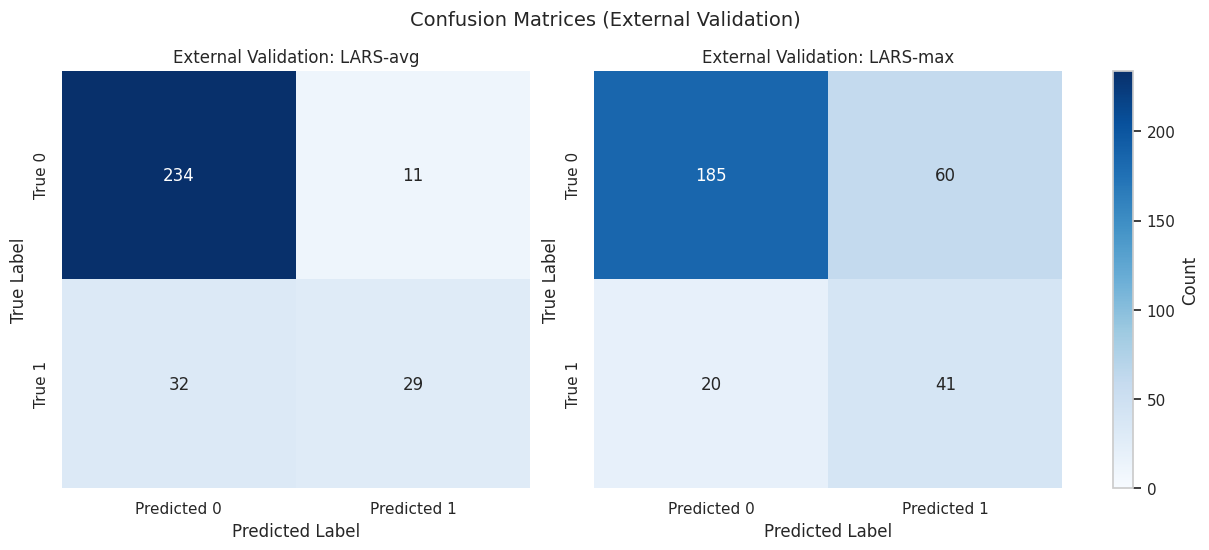


LARS-avg External Validation: False Positives: 11, False Negatives: 32
LARS-max External Validation: False Positives: 60, False Negatives: 20


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume ensemble_avg and ensemble_max DataFrames are already available
# and they contain at least the following columns: 'target', 'pred_label', and 'scan_id'

# Compute confusion matrices for both variants
cm_avg = confusion_matrix(ensemble_avg['target'], ensemble_avg['pred_label'])
cm_max = confusion_matrix(ensemble_max['target'], ensemble_max['pred_label'])

# Print detailed classification reports for both
print("Detailed Classification Report (LARS-avg External Validation):")
print(classification_report(ensemble_avg['target'], ensemble_avg['pred_label']))
print("\nDetailed Classification Report (LARS-max External Validation):")
print(classification_report(ensemble_max['target'], ensemble_max['pred_label']))

# Determine the maximum value across both confusion matrices for shared scaling
max_val = max(cm_avg.max(), cm_max.max())

# 3) Determine the maximum value across both confusion matrices for a shared scale
max_val = max(cm_avg.max(), cm_max.max())

# 4) Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# We'll first plot each heatmap with cbar=False so we can add a single color bar after.
im0 = sns.heatmap(cm_avg, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[0],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[0].set_title("External Validation: LARS-avg")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

im1 = sns.heatmap(cm_max, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[1],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[1].set_title("External Validation: LARS-max")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# 5) Add one common color bar using the first heatmap's “collections”
cbar = fig.colorbar(im0.collections[0], ax=axs, shrink=1, label='Count')


plt.suptitle("Confusion Matrices (External Validation)", fontsize=14, y=1.07)
plt.show()
plt.show()

# Report false positives and false negatives for each variant
fp_avg = ensemble_avg[(ensemble_avg['target'] == 0) & (ensemble_avg['pred_label'] == 1)]
fn_avg = ensemble_avg[(ensemble_avg['target'] == 1) & (ensemble_avg['pred_label'] == 0)]
fp_max = ensemble_max[(ensemble_max['target'] == 0) & (ensemble_max['pred_label'] == 1)]
fn_max = ensemble_max[(ensemble_max['target'] == 1) & (ensemble_max['pred_label'] == 0)]

print(f"\nLARS-avg External Validation: False Positives: {len(fp_avg)}, False Negatives: {len(fn_avg)}")
print(f"LARS-max External Validation: False Positives: {len(fp_max)}, False Negatives: {len(fn_max)}")
